<a href="https://colab.research.google.com/github/yh08037/ABR-Lab-Summer-Project/blob/master/DogBreed_with_Generator_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
# 구글드라이브 파일 읽기 위한 연동 용 라이브러리
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.4MB/s 


In [3]:
# 실질적으로 구글드라이브에서 파일을 불러오는 방법입니다.
# 위에서 준비해두었던 공유 가능한 링크에서 'id=' 이후에 있는 문자열을 복사하여 file_id로 사용합니다.
train_id = '1squZt709J4AEdrADfOrHEuBRc8GWFeI-'
valid_id = '1caXSPr2RKOopOoS2FevrC6qJc3AEMAe9'
test_id = '1j4gbulbo60cKxW2OXSDIaHrUUZV9RiXY'

downloaded = drive.CreateFile({'id': train_id})  # file_id로부터 파일 객체를 생성
downloaded.GetContentFile('train.zip')           # 불러온 파일 객체를 Colab에 저장

downloaded = drive.CreateFile({'id': valid_id})  
downloaded.GetContentFile('valid.zip')          

downloaded = drive.CreateFile({'id': test_id}) 
downloaded.GetContentFile('test.zip')         

# 압축해제
!unzip train.zip
!unzip valid.zip
!unzip test.zip

Archive:  train.zip
   creating: train/
   creating: train/n02098413-Lhasa/
  inflating: train/n02098413-Lhasa/n02098413_2911.jpg  
  inflating: train/n02098413-Lhasa/n02098413_11467.jpg  
  inflating: train/n02098413-Lhasa/n02098413_2954.jpg  
  inflating: train/n02098413-Lhasa/n02098413_13083.jpg  
  inflating: train/n02098413-Lhasa/n02098413_1457.jpg  
  inflating: train/n02098413-Lhasa/n02098413_624.jpg  
  inflating: train/n02098413-Lhasa/n02098413_3411.jpg  
  inflating: train/n02098413-Lhasa/n02098413_10144.jpg  
  inflating: train/n02098413-Lhasa/n02098413_8297.jpg  
  inflating: train/n02098413-Lhasa/n02098413_1473.jpg  
  inflating: train/n02098413-Lhasa/n02098413_2047.jpg  
  inflating: train/n02098413-Lhasa/n02098413_10285.jpg  
  inflating: train/n02098413-Lhasa/n02098413_2607.jpg  
  inflating: train/n02098413-Lhasa/n02098413_3285.jpg  
  inflating: train/n02098413-Lhasa/n02098413_3899.jpg  
  inflating: train/n02098413-Lhasa/n02098413_1655.jpg  
  inflating: train/n02098

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

train_datagen = train_datagen.flow_from_directory(
    directory='/content/train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    )

valid_datagen = valid_datagen.flow_from_directory(
    directory='/content/valid',
    target_size=(224, 224),
    batch_size=BATCH_SIZE)

test_datagen = test_datagen.flow_from_directory(
    directory='/content/test',
    target_size=(224, 224),
    batch_size=BATCH_SIZE)

Found 18658 images belonging to 120 classes.
Found 961 images belonging to 120 classes.
Found 961 images belonging to 120 classes.


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet')
model.trainable = False
output = keras.layers.Dense(120, 'softmax')(model.layers[-1].output)
logits = keras.layers.Dropout(0.5)(output)
model = keras.models.Model(model.inputs, logits)
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________

In [6]:
len(model.trainable_variables)

2

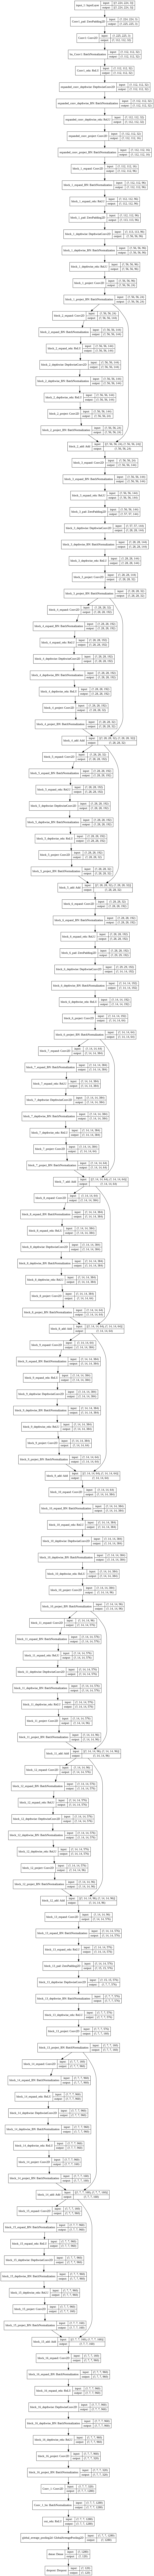

In [7]:
keras.utils.plot_model(model, 'mobilenetv2.png', show_shapes=True)

In [0]:
STEP_SIZE_TRAIN = train_datagen.n // train_datagen.batch_size
STEP_SIZE_VALID = valid_datagen.n // valid_datagen.batch_size

In [0]:
model.fit_generator(generator=train_datagen, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data = valid_datagen,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=20)

Epoch 1/20


/tensorflow-2.0.0-rc0/python3.6/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/tensorflow-2.0.0-rc0/python3.6/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
583/583 [==============================] - 328s 563ms/step - loss: 9.0820 - accuracy: 0.2312 - val_loss: 1.4591 - val_accuracy: 0.5990
Epoch 2/20
583/583 [==============================] - 325s 557ms/step - loss: 8.6556 - accuracy: 0.3235 - val_loss: 1.3346 - val_accuracy: 0.6031
Epoch 3/20
583/583 [==============================] - 326s 559ms/step - loss: 8.7234 - accuracy: 0.3308 - val_loss: 1.2043 - val_accuracy: 0.6500
Epoch 4/20
583/583 [==============================] - 327s 560ms/step - loss: 8.6467 - accuracy: 0.3430 - val_loss: 1.2949 - val_accuracy: 0.6385
Epoch 5/20
583/583 [==============================] - 327s 561ms/step - loss: 8.6614 - accuracy: 0.3482 - val_loss: 1.2077 - val_accuracy: 0.6562
Epoch 6/20
583/583 [==============================] - 324s 556ms/step - loss: 8.5902 - accuracy: 0.3553 - val_loss: 1.2911 - val_accuracy: 0.6594
Epoch 7/20
583/583 [=====================

In [0]:
model.evaluate_generator(generator=test_datagen)